# Monte Carlo ES for Blackjack

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

random.seed(7)

### State Space and Action Space
A state $(x, y)$ consists of two values, with $x \in \{12, 13, 14, ..., 22\}$ indicating the current sum of the player and $y \in \{Ace = 11, 2, 3, ..., 10\}$ indicating the dealer's shown card value.\
An action $a \in \{0, 1\}$, with 0 indicating stick and 1 indictaing hit.

In [2]:
# State space & Action space
S = [(i,j) for i in range(12,23) for j in range(2,12)]
A = [0, 1]

# Initialization
# Note that for the initial policy, we only stick when the player's sum is larger or equal to 20
def initialization(S, A):
    Pi = dict()
    Q = dict()
    Returns = dict()
    for s in S:
        if s[0] >= 20:
            Pi[s] = 0
        else:
            Pi[s] = 1
        for a in A:
            Q[(s, a)] = 0
            Returns[(s, a)] = []
    return Pi, Q, Returns

In [3]:
# This function generates a card value
# Note that every card (Ace, 2, 3, ..., J, Q, K) has equal probability 1/13 of showing up
# which means the value in our setting is (11, 2, 3, ..., 10) where 10 has prob 4/13 and others with prob 1/13
def hit():
    card = random.randint(1, 13)
    if card == 1:
        return 11
    elif card in [11, 12, 13]:
        return 10
    else:
        return card

In [4]:
# This function generates an episode fromn S0, A0, following Pi
def generate_episode(S0, A0, Pi):
    episode = []
    episode.append(S0)
    episode.append(A0)
    s = S0
    a = A0
    
    # Player Hits
    while True:
        if a == 1:
            new_card = hit()
            player_value = s[0] + new_card
            if player_value > 22:
                episode.append(-1)
                return episode
            else:
                s = (player_value, s[1])
                episode.append(s)
                a = Pi[s]
                episode.append(a)
        else:
            break
    
    # Dealer Hits
    dealer_sum = s[1] + hit()
    while dealer_sum <= 16:
        new_card = hit()
        dealer_sum += new_card
        if dealer_sum > 22:
            episode.append(1) 
            return episode
    
    # Generate return when no one bursts
    if s[0] > dealer_sum:
        episode.append(1)
    elif s[0] < dealer_sum:
        episode.append(-1)
    else:
        episode.append(0)
    return episode

In [5]:
# This function evaluates the current policy Pi by running NUM_EPISODES episodes and calculate the average return
def evaluation(S, Pi, NUM_EPISODES):
    S0 = random.choice(S)
    A0 = Pi[S0]
    R = 0
    for episode_num in range(NUM_EPISODES):
        episode = generate_episode(S0, A0, Pi)
        R += episode[-1]
    return R/NUM_EPISODES

In [6]:
# This is the main loop for MCES for estimating optimal policy
# We train for NUM_LOOP times and every EVAL_EVERY_NUM training epochs, 
# we evaluate the returns over NUM_EVAL_EPISODES number of episodes
def MCES_main(S, A, NUM_LOOP, EVAL_EVERY_NUM, NUM_EVAL_EPISODES):
    Pi, Q, Returns = initialization(S, A)
    eval_return_history = []
    for i in range(NUM_LOOP):
        S0 = random.choice(S)
        A0 = random.choice(A)
        episode = generate_episode(S0, A0, Pi)
        G = episode[-1]
        T = len(episode)//2
        # Policy Improvement
        for t in range(T-1,-1,-1):
            state_action = (episode[2*t], episode[2*t+1])
            Returns[state_action].append(G)
            Q[state_action] = sum(Returns[state_action])/len(Returns[state_action])
            s = state_action[0]
            if Q[(s, 0)] > Q[(s, 1)]:
                Pi[s] = 0
            elif Q[(s, 1)] > Q[(s, 0)]:
                Pi[s] = 1
        # Evaluation (if applicable)
        if (i+1)%EVAL_EVERY_NUM == 0:
            eval_return = evaluation(S, Pi, NUM_EVAL_EPISODES)
            eval_return_history.append(eval_return)
    return eval_return_history, Pi

In [7]:
def display_policy(Pi):
    Policy = np.zeros((11, 10))
    for i in range(11):
        for j in range(10):
            Policy[i][j] = Pi[(i+12, j+2)]
    im = plt.imshow(Policy, cmap="copper_r")
    plt.colorbar(im)
    plt.show()
    

### Run for Original Version
After training $n*1000$ steps, run $100$ episodes with the current policy (no random initial action) and calculate the average return for those $100$ episodes. Provide the average returns for $n =1,2,...,20$. 

Optimal Policy



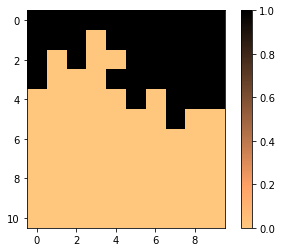

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
average return,0.91,0.94,-0.17,-0.36,0.15,0.05,0.84,0.59,0.58,0.31,-0.25,-0.49,-0.33,-0.48,0.14,-0.46,-0.61,0.03,0.33,-0.12


In [8]:
def main_original_version(S, A):
    N = [n for n in range(1, 21)]
    return_history = []
    for n in N:
        NUM_LOOP = n*1000
        EVAL_EVERY_NUM = NUM_LOOP
        NUM_EVAL_EPISODES = 100
        eval_return_history, Pi = MCES_main(S, A, NUM_LOOP, EVAL_EVERY_NUM, NUM_EVAL_EPISODES)
        return_history.append(eval_return_history[0])
    d = {'average return':return_history}
    df = pd.DataFrame(data = d, index = N)
    print("Optimal Policy\n")
    display_policy(Pi)
    return df
    
df = main_original_version(S, A)
df.T

### Run for New Version
Train for 100,000 steps (instead of 20,000 steps)\
Every 1000 steps, evaluate the current policy by running 1000 episodes and averaging over the 1000 episodes

return history = [-0.224, 0.069, -0.554, -0.392, -0.173, -0.41, 0.899, 0.856, 0.249, -0.089, 0.899, -0.45, 0.7, -0.097, 0.955, 0.149, -0.462, 0.934, 0.269, -0.13, 0.926, -0.566, -0.26, -0.174, 0.923, -0.573, -0.115, -0.305, 0.519, 0.717, 0.94, -0.332, 0.845, -0.389, -0.264, -0.474, 0.901, -0.338, -0.312, 0.941, -0.312, 0.801, -0.379, 0.013, 0.0, -0.372, -0.296, -0.223, 0.907, 0.057, 0.276, -0.306, 0.194, 0.143, 0.266, -0.124, -0.351, -0.4, -0.382, -0.504, -0.162, 0.671, -0.291, 0.303, 0.614, 0.905, -0.292, -0.289, 0.267, 0.08, -0.554, -0.437, 0.256, 0.129, 0.499, 0.329, -0.344, -0.142, 0.934, 0.482, 0.208, -0.428, 0.92, -0.349, -0.378, 0.17, -0.278, -0.256, 0.901, 0.16, -0.505, 0.845, -0.302, -0.316, 0.702, -0.496, -0.385, 0.941, 0.182, 0.278]


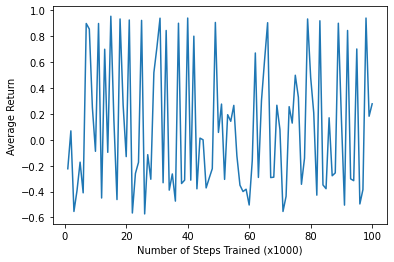

Optimal Policy



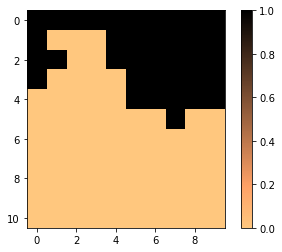

In [9]:
def main_new_version(S, A):
    NUM_LOOP = 100000
    EVAL_EVERY_NUM = 1000
    NUM_EVAL_EPISODES = 1000
    eval_return_history, Pi = MCES_main(S, A, NUM_LOOP, EVAL_EVERY_NUM, NUM_EVAL_EPISODES)
    print("return history =", eval_return_history)
    plt.figure()
    plt.plot([x+1 for x in range(100)], eval_return_history)
    plt.xlabel("Number of Steps Trained (x1000)")
    plt.ylabel("Average Return")
    plt.show()
    print("Optimal Policy\n")
    display_policy(Pi)
     
    
main_new_version(S, A)